# CloudMasking and NDVI calculation 

Image has been downloaded from scihub for date 23 August 2022 around Dehradun region as a reference image.
Following libraries has been read for processing

In [1]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

### Cloud Masking

Cloud mask has been created using cloud mask quality flag file present in the downloaded data at following location.

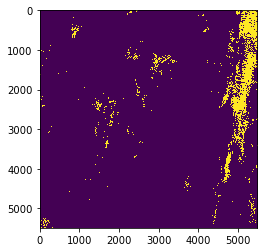

In [6]:
imagePath = 'Downloads/S2A_MSIL2A_20220623T052701_N0400_R105_T43RGP_20220623T101018.SAFE/GRANULE/L2A_T43RGP_A036567_20220623T053132/QI_DATA/'
cloud_mask = rasterio.open(imagePath+'MSK_CLDPRB_20m.jp2', driver='JP2OpenJPEG') #cloud

#imag read as an array
mask_array = cloud_mask.read(1)

#cloud less than given value

CLOUD_PIXEL_PERCTANGE = 10   # define cloud pixel percentage here
mask_array[mask_array < CLOUD_PIXEL_PERCTANGE] = 0
mask_array[mask_array >= CLOUD_PIXEL_PERCTANGE] = 1
plot.show(mask_array)

After creating mask, it has been applied on Green, Red, NIR band and stacked to created false color composite maps for visualization

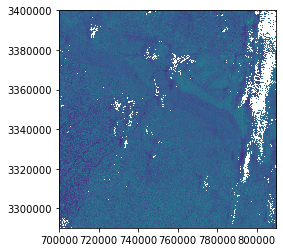

In [7]:
#import bands as separate 1 band raster
imagePath = 'Downloads/S2A_MSIL2A_20220623T052701_N0400_R105_T43RGP_20220623T101018.SAFE/GRANULE/L2A_T43RGP_A036567_20220623T053132/IMG_DATA/R20m/'
band3 = rasterio.open(imagePath+'T43RGP_20220623T052701_B03_20m.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open(imagePath+'T43RGP_20220623T052701_B04_20m.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open(imagePath+'T43RGP_20220623T052701_B8A_20m.jp2', driver='JP2OpenJPEG') #nir

#reading bands as an array
bandGreen = band3.read(1)
bandRed = band4.read(1)
bandNIR = band8.read(1)

# Applying Scale factor for Sentinel-2 image
bandGreen= np.divide(bandGreen, 10000)
bandRed= np.divide(bandRed, 10000)
bandNIR = np.divide(bandNIR, 10000)

#Declaring cloduy pixels to NAN
bandGreen[mask_array == 1] = np.nan
bandRed[mask_array == 1] = np.nan
bandNIR[mask_array == 1] = np.nan

#Writing False Color Composite Image
falseColor = rasterio.open('SentinelFalseColorScaled.tif', 'w', driver='Gtiff',
                          width=band4.width, height=band4.height,
                          count=3,
                          crs=band4.crs,
                          transform=band4.transform,
                          dtype='float64'                   
                         )

falseColor.write(bandGreen,3) #Blue
falseColor.write(bandRed,2) #Green
falseColor.write(bandNIR,1) #Red
falseColor.close()
src = rasterio.open(r"SentinelFalseColorScaled.tif", count=3)
plot.show(src)

### NDVI calculation

NDVI has been calculated using normalized difference if NIR and Red band

/tmp/ipykernel_102753/1726618416.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = (bandNIR-bandRed)/(bandNIR+bandRed)


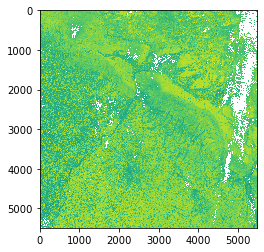

In [8]:
# creating empty NDVI array
ndvi = np.zeros(band4.shape)
ndvi = (bandNIR-bandRed)/(bandNIR+bandRed)
#masking NDVI with cloudy Pixels
ndvi[mask_array == 1] = np.nan
#Giving arhuments to NDVI files
kwargs = band4.meta
kwargs.update(
    driver='GTIFF',
    dtype=rasterio.float32,
    count=1,
    compress='lzw')

with rasterio.open('NDVI_S2.tif', 'w', **kwargs) as dst:
    dst.write_band(1, ndvi)

plot.show(ndvi)

### Clip to 1 sq km

As given image is metres (WGS 84 / UTM zone 43N), so a random 1 sq km boundary has been created to clip NDVI file


/home/luckyw0w/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/luckyw0w/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/luckyw0w/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.

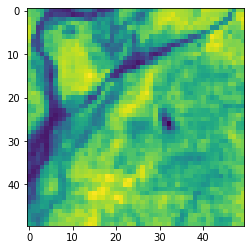

In [9]:
# Creating bounding box to clip
minx, miny = 740000, 3360000
maxx, maxy = 741000, 3361000
bbox = box(minx, miny, maxx, maxy)

#Create GeoDataFrame to read it as a geojson
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32643))
geo = geo.to_crs(crs=band4.crs.data)

#  A geojson returning function
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)

#Clipping NDVI file with given bounding box
ndvi_img = rasterio.open('NDVI_S2.tif', driver='GTIFF') #nir
out_img, out_transform = mask(ndvi_img, coords, crop=True)
# Giving arguments for clippedf NDVI file
out_meta = band8.meta
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "dtype":rasterio.float32})

#writing NDVI file
with rasterio.open("NDVI_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_img)

plot.show(out_img)